## Suggested Edits in Wikipedia Android app

[Suggested Edits](https://www.mediawiki.org/wiki/Wikimedia_Apps/Suggested_edits) feature is part of the overall plan to improve in-app editing in the Wikipedia Android app. Once a registered user unlocks the feature (see below for details), they are presented with "edit tasks" in the Editor Tasks workflow, which provide suggestions of articles which need a title description added or translated. The main idea behind this feature is that it would enable users to make many title description edits (Wikidata descriptions) in rapid succession and repeatedly over time.

The first version of the app which had the feature and integration with the backend service/API was released as a [public beta on the Google Play Store](https://play.google.com/store/apps/details?id=org.wikipedia.beta) on 5 April 2019. The [production version](https://play.google.com/store/apps/details?id=org.wikipedia) was made available in the Play Store on 23 April 2019.

This report is updated automatically on [Simple Wikimedia Analytics Platform](https://wikitech.wikimedia.org/wiki/SWAP) at 5AM UTC every day. It may take 15-30 minutes for the update to be published.

In [1]:
# https://stackoverflow.com/a/35018739/1091835
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

## Table of Contents

1. [Unlock stats](#Unlock-stats)
2. [Edit stats](#Edit-stats)
    1. [Edits and editors](#Edits-and-editors)
    2. [Revert-rate](#Revert-rate)
3. [Usage stats](#Usage-stats)
    1. [Engagement](#Engagement)
    2. [Help and Scorecard](#Help-and-Scorecard)
    3. [Time spent](#Time-spent)
    4. [Interaction with suggestions](#Interaction-with-suggestions)
4. [Retention stats](#Retention-stats)

In [2]:
# Packages:
library(glue)
library(zeallot)
library(magrittr)
import::from(dplyr, group_by, keep_where = filter, ungroup, summarize,
             mutate, rename, select, arrange, n, left_join, distinct)
import::from(tidyr, spread, gather)
library(ggplot2)
# library(ggrepel)
import::from(wmf, theme_min, theme_facet)
import::from(polloi, compress)
library(repr)
library(patchwork)

In [3]:
# Helper functions:
inf2na <- function(x) {
    y <- x
    y[is.infinite(x)] <- NA
    return(y)
}
nan2na <- function(x) {
    y <- x
    y[is.nan(x)] <- NA
    return(y)
}
na2zero <- function(x) {
    y <- x
    y[is.na(x)] <- 0
    return(y)
}
suppress_messages_warnings <- function(x) {
    suppressMessages(suppressWarnings(x))
}

In [4]:
today <- Sys.Date()
yesterday <- today - 1
feature_release_dates <- dplyr::tibble(
    date = as.Date(c("2019-04-05", "2019-04-23")),
    release = c("Beta launch", "Production launch")
)
usage_date_range <- c(feature_release_dates$date[feature_release_dates$release == "Production launch"], yesterday)

## Unlock stats

The Editor Tasks backend service and API (maintained by [Reading Infrastructure team](https://www.mediawiki.org/wiki/Wikimedia_Reading_Infrastructure_team)) keep track of how many title description edits each app user has made since the launch of the service on 5 April 2019. Once a user makes enough edits that have not been reverted in 48 hours (to prevent unlocking the feature through vandalism), the service makes the first edit task (adding descriptions) available to the user. When the app pings the API, the API tells the app that that edit task is unlocked and the user receives an in-app notification:

<img src="suggested_edits_unlocked.png" alt="In-app notification of Suggested Edits feature unlocking" style="width:40%;display:inline;" />

After 50 title description edits, the API tells the app that the user has unlocked the second edit task (translating descriptions). We can count how many users' contributions are tracked by the Editor Tasks backend service and how many of those users have unlocked the feature by satisfying the necessary criterion (5 title descriptions at launch, but can be adjusted in the future):

In [5]:
api_query <- "
SELECT
  counts.wetc_user AS user_id,
  -- SUM(IF(legend.wet_key = 'app_description_edits', counts.wetc_count, 0)) AS n_adds,
  SUM(counts.wetc_count) AS n_edits,
  MIN(unlocks.wettp_effective_time) AS unlock_ts
FROM wikimedia_editor_tasks_counts counts
-- LEFT JOIN wikimedia_editor_tasks_keys legend ON counts.wetc_key_id = legend.wet_id
LEFT JOIN wikimedia_editor_tasks_targets_passed unlocks ON counts.wetc_user = unlocks.wettp_user
GROUP BY user_id
"

In [6]:
suppress_messages_warnings({
    backend_data <- api_query %>%
        wmf::mysql_read(database = "wikishared", use_x1 = TRUE) %>%
        mutate(
            unlock_ts = lubridate::ymd_hms(unlock_ts),
            unlocked = !is.na(unlock_ts),
            date = as.Date(unlock_ts)
        )
})

In [7]:
total_editors <- nrow(backend_data)
backend_stats <- backend_data %>%
    keep_where(unlocked, date < today) %>%
    arrange(date) %>%
    group_by(date) %>%
    summarize(unlocked = sum(unlocked)) %>%
    mutate(cumulative = cumsum(unlocked), prop = cumulative / total_editors)

The total number of editors who have unlocked Suggested Edits as of this report's update, out of the total logged-in users on Android who have started using the new versions of the app (which have the feature):

In [8]:
cat(tail(backend_stats, 1)$cumulative, "out of possible", total_editors)

632 out of possible 2495

**Note**: on desktop and mobile web the main benefit of registering and being logged in is the ability to set preferences, but otherwise there are no reading benefits. On mobile apps, users who log in can sync their reading lists to their account, so there is a strong incentive to use an account even if user has no intention of ever editing.

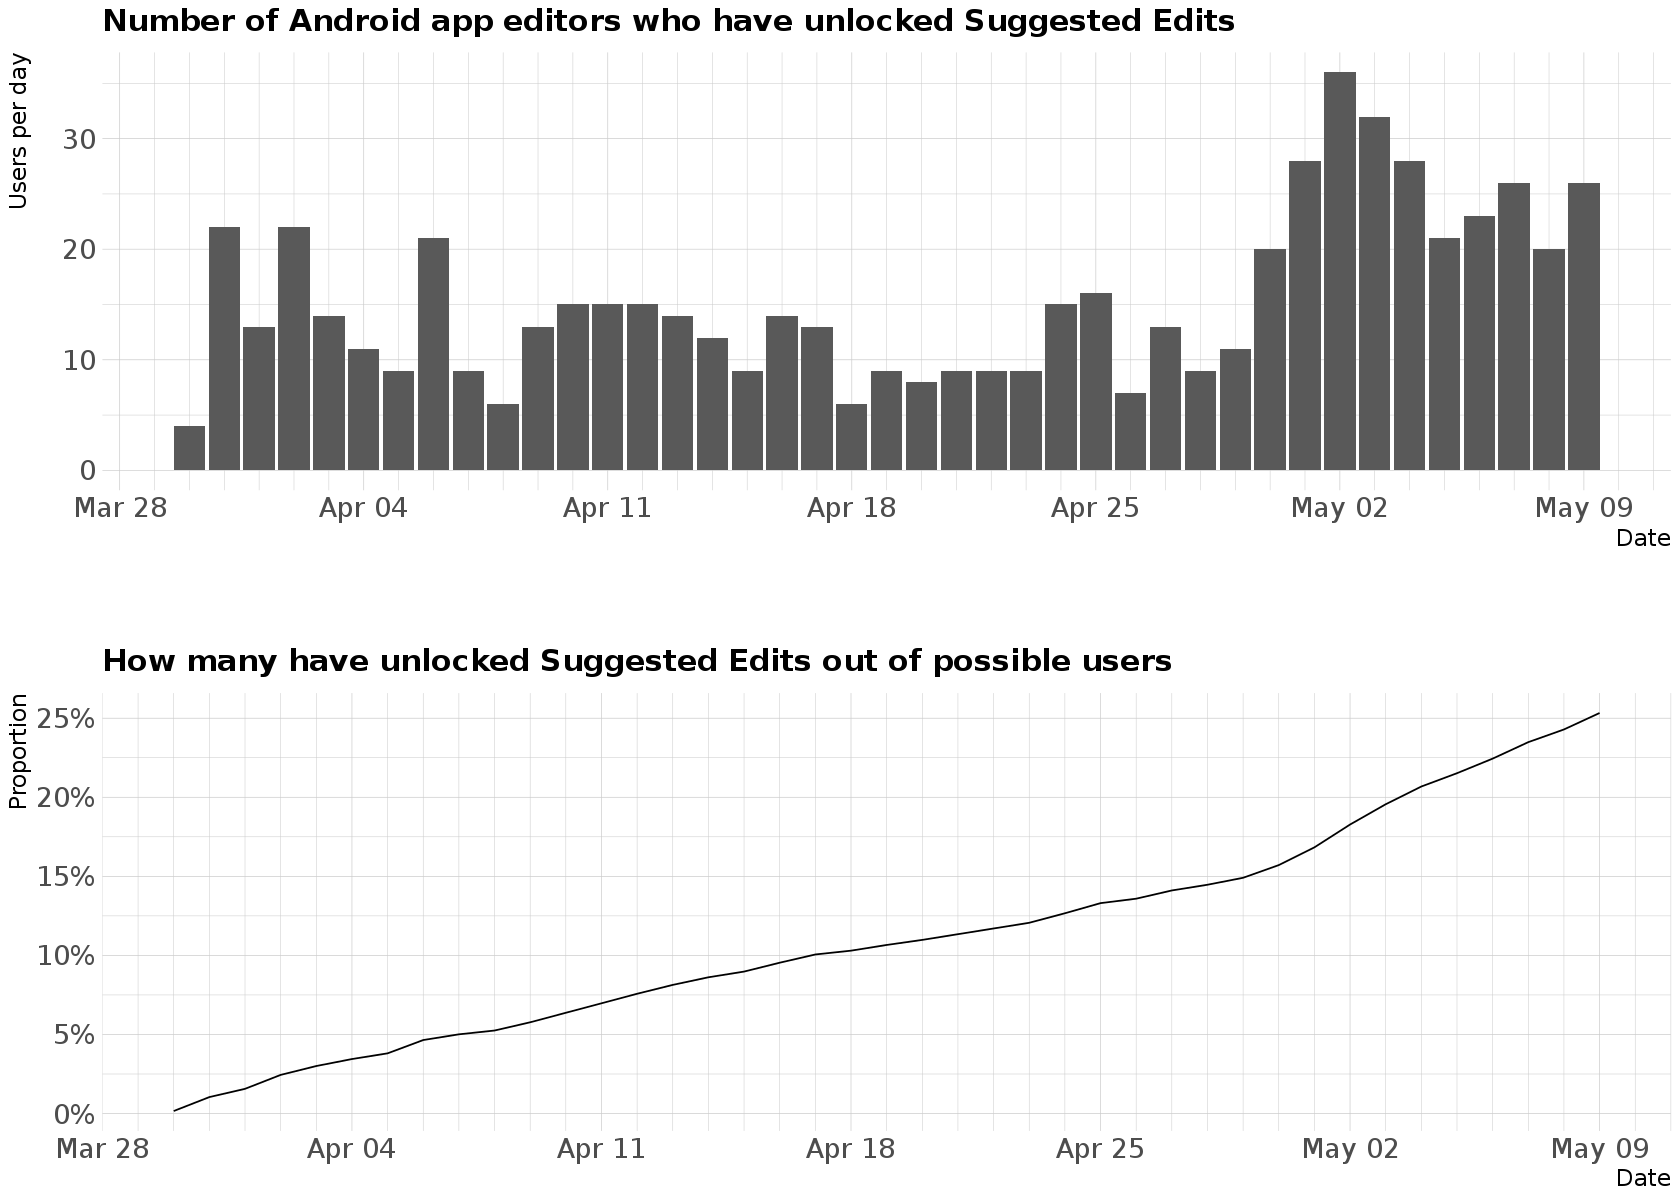

In [9]:
options(repr.plot.width = 14, repr.plot.height = 10)
p1 <- ggplot(backend_stats, aes(x = date, y = unlocked)) +
    geom_col() +
    scale_y_continuous(labels = compress) +
    scale_x_date(date_breaks = "7 days", date_minor_breaks = "1 day", date_labels = "%b %d") +
    hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold",
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14) +
    labs(x = "Date", y = "Users per day", title = "Number of Android app editors who have unlocked Suggested Edits")
p2 <- ggplot(backend_stats, aes(x = date, y = prop)) +
    geom_line() +
    scale_y_continuous(labels = scales::percent_format(1)) +
    scale_x_date(date_breaks = "7 days", date_minor_breaks = "1 day", date_labels = "%b %d") +
    hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold",
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14) +
    labs(x = "Date", y = "Proportion", title = "How many have unlocked Suggested Edits out of possible users")
p1 + p2 + plot_layout(ncol = 1)

**Note**: if you see dates 1-2 days into the future, that's *probably* because the backend service flags users as having unlocked the feature 2 days from their the unlocking edit, but then checks if those edits have been reverted or not after 48 hours.

## Edit stats

### Edits and editors

In [10]:
mw_query <- "
SELECT
  rev_user = 0 AS anon,
  COUNT(DISTINCT rev_user_text) AS total_users,
  SUBSTR(rev_timestamp, 1, 8) AS `date`,
  COUNT(1) AS total_edits,
  SUM(IF(INSTR(rev_comment, '#suggestededit') > 0 OR INSTR(comment_text, '#suggestededit') > 0, 1, 0)) AS suggested_edits
FROM revision
LEFT JOIN revision_comment_temp rct ON revision.rev_id = rct.revcomment_rev
LEFT JOIN `comment` ON rct.revcomment_comment_id = `comment`.comment_id
LEFT JOIN change_tag ON revision.rev_id = change_tag.ct_rev_id
WHERE rev_timestamp >= '20190401'
  AND ct_tag_id = 14 -- android app edit
  -- AND rev_user > 0 -- anonymous edits
GROUP BY anon, `date`;
"

In [11]:
# edit_data <- suppress_messages_warnings(wmf::mysql_read(mw_query, "wikidatawiki")) %>%
#     mutate(date = as.Date(date, "%Y%m%d"), anon = anon == 1)

In [12]:
editor_query <- "
SELECT
  rev_user AS user_id,
  SUBSTR(rev_timestamp, 1, 8) AS `date`,
  SUM(IF(INSTR(rev_comment, '#suggestededit') > 0 OR INSTR(comment_text, '#suggestededit') > 0, 1, 0)) AS suggested_edits,
  COUNT(1) AS total_edits
FROM revision
LEFT JOIN revision_comment_temp rct ON revision.rev_id = rct.revcomment_rev
LEFT JOIN `comment` ON rct.revcomment_comment_id = `comment`.comment_id
LEFT JOIN change_tag ON revision.rev_id = change_tag.ct_rev_id
WHERE rev_timestamp >= '20190401'
  AND rev_user > 0 -- remove anon edits
  AND ct_tag_id = 14 -- android app edit
GROUP BY user_id, `date`;
"

In [13]:
editor_data <- suppress_messages_warnings(wmf::mysql_read(editor_query, "wikidatawiki")) %>%
    mutate(date = as.Date(date, "%Y%m%d"))

Title descriptions made through the Suggested Edits feature have the comment "#suggestededit", which enables us to differentiate between those edits and regular edits (which can be made when reading an article).

The following is a breakdown of how many title description edits have been made with the feature (and without it) and how many editors have made Wikidata description edits through the Suggested Edits feature (the Editor Tasks screen/workflow) each day. This includes the Mobile Apps and Reading Infrastucture teams who have made contributions as part of the development and QA, prior to the public release of the beta and production versions of the app.

In [14]:
made_with <- editor_data %>%
    keep_where(date < today & date >= "2019-04-04") %>%
    mutate(non_suggested_edits = total_edits - suggested_edits) %>%
    group_by(date) %>%
    summarize(
         `outside Suggested Edits` = sum(non_suggested_edits),
         `inside Suggested Edits` = sum(suggested_edits)
    )
contributor_counts <- editor_data %>%
    keep_where(date < today & date >= "2019-04-04") %>%
    keep_where(suggested_edits > 0) %>%
    arrange(user_id, date) %>%
    group_by(user_id) %>%
    mutate(returning = date > min(date)) %>%
    ungroup %>%
    dplyr::count(date, returning) %>%
    mutate(returning = factor(returning, c(FALSE, TRUE), c("First-time", "Returning")))
# edit_date_range <- range(c(range(made_with$date), range(contributor_counts$date)))
edit_date_range <- c(as.Date("2019-04-04"), yesterday)

In [15]:
p1 <- made_with %>%
    gather(made, edits, -date) %>%
    ggplot() +
    geom_vline(aes(xintercept = date), data = feature_release_dates, linetype = "dashed", color = "gray50") +
    geom_label(aes(x = date, y = 800, label = release), data = feature_release_dates, size = 5, nudge_y = 50) +
    geom_col(aes(x = date, y = edits, fill = made), position = "stack", color = "white") +
    geom_label(
        aes(x = date, y = `outside Suggested Edits` + `inside Suggested Edits`,
            label = compress(`inside Suggested Edits`)),
        data = keep_where(made_with, `inside Suggested Edits` > 0), color = "#dd3333", nudge_y = 50, size = 5, hjust = "center"
    ) +
    scale_fill_manual(
        values = c("inside Suggested Edits" = "#dd3333", "outside Suggested Edits" = "#3366cc")
    ) +
    scale_x_date(date_breaks = "7 days", date_minor_breaks = "1 day", date_labels = "%b %d\n(%a)", expand = c(0, 1)) +
    scale_y_continuous(minor_breaks = NULL, labels = compress) +
    coord_cartesian(xlim = edit_date_range) +
    hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold",
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14) +
    theme(legend.position = "bottom", panel.grid.minor.y = element_blank(), legend.text = element_text(size = 18)) +
    labs(
        x = "Date", y = "Edits", fill = "Made",
        title = "Title description edits made with Wikipedia Android app"
    )

In [16]:
p2 <- ggplot(contributor_counts, aes(x = date, y = n, fill = returning)) +
    geom_col(position = "stack", color = "white") +
    scale_y_continuous(labels = compress, minor_breaks = NULL) +
    scale_x_date(date_breaks = "7 days", date_minor_breaks = "1 day", date_labels = "%b %d\n(%a)", expand = c(0, 1)) +
    coord_cartesian(xlim = edit_date_range) +
    hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold",
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14) +
    theme(legend.position = "bottom", panel.grid.minor.y = element_blank(), legend.text = element_text(size = 18)) +
    labs(x = "Date", y = "Editors", fill = "Suggested Edits feature users",
         title = "Editors who contributed through the Suggested Edits feature, per day")

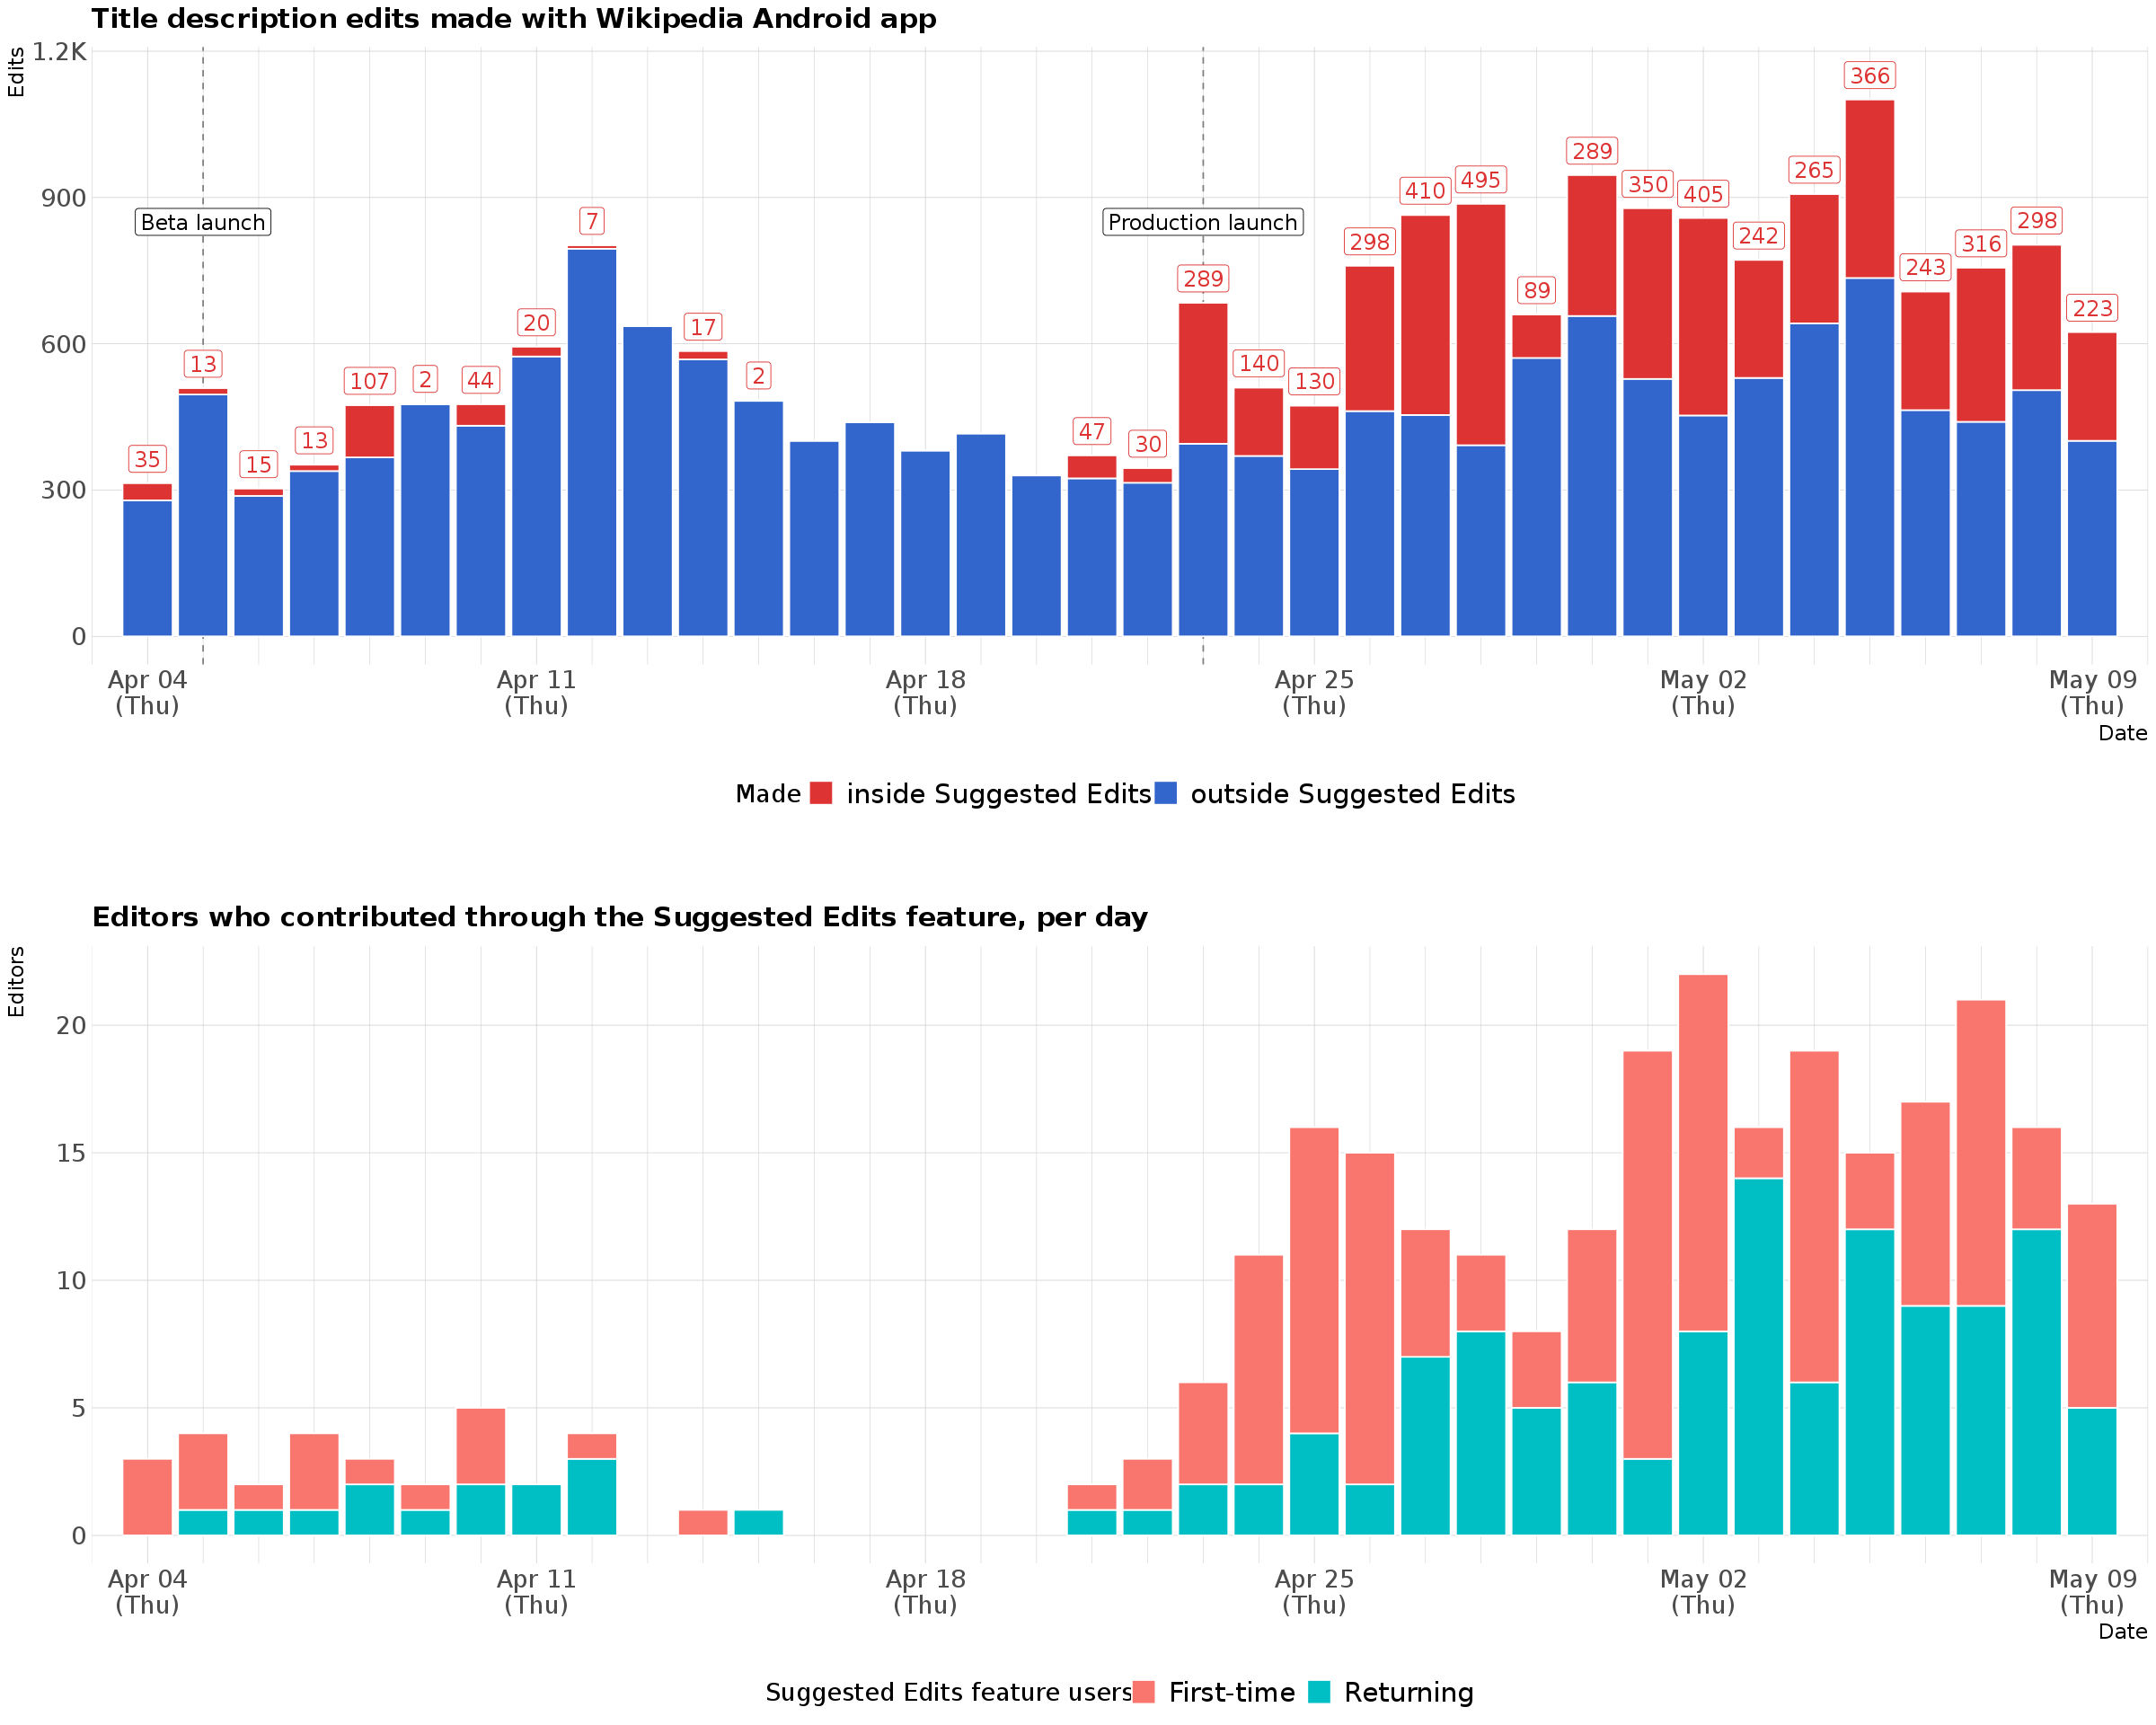

In [17]:
options(repr.plot.width = 20, repr.plot.height = 16)
p1 + p2 + plot_layout(ncol = 1)

**How to read the two charts above**: on 8 April 2019, there were 3 total editors who collectively made 108 edits through the Editor Tasks (Suggested Edits) workflow. Of those 3 editors, 1 was somebody who made a contribution through Suggested Edits for the first time and 2 others were editors who have Suggested Edits-made contributions to their name already.

### Top Suggested Edits users

The following is an anonymized leaderboard of top 10 (or more if there are ties) editors by total number of edits made through the Suggested Edits feature:

In [18]:
revert_status_data <- readr::read_csv("revert_status_data.csv.gz", col_types = "DTiiicli", progress = FALSE) %>%
    mutate(made = factor(edit_type, c("suggested", "regular"), c("inside Suggested Edits", "outside Suggested Edits")))

In [19]:
editor_reverts <- revert_status_data %>%
    keep_where(edit_type == "suggested", rev_date >= "2019-04-05") %>%
    group_by(user_id) %>%
    summarize(reverted = sum(reverted))
editor_data %>%
    keep_where(suggested_edits > 0) %>%
    group_by(user_id) %>%
    summarize(
        days = dplyr::n(),
        total = sum(suggested_edits),
        avg = round(mean(suggested_edits))
    ) %>%
    dplyr::top_n(10, total) %>%
    arrange(dplyr::desc(total), dplyr::desc(days)) %>%
    left_join(editor_reverts, by = "user_id") %>%
    mutate(
        revert_rate = scales::percent_format(0.1)(reverted / total),
        rank = 1:dplyr::n()
    ) %>%
    select(
        Rank = rank, `Days of SE use*` = days,
        `Total SE edits` = total, `Average SE edits/day` = avg,
        `Reverted SE edits` = reverted, `SE revert rate` = revert_rate
    )

Rank,Days of SE use*,Total SE edits,Average SE edits/day,Reverted SE edits,SE revert rate
1,12,1341,112,0,0.0%
2,4,457,114,0,0.0%
3,10,314,31,0,0.0%
4,6,281,47,0,0.0%
5,3,278,93,0,0.0%
6,2,119,60,0,0.0%
7,1,105,105,0,0.0%
8,9,84,9,0,0.0%
9,4,79,20,0,0.0%
10,4,74,18,0,0.0%


<span style="font-size:x-small;">__\*__ since beta release on 2019-04-05</span>

### Revert rate

Using the [`mwreverts` library](https://pythonhosted.org/mwreverts/) we can query the MediaWiki API to check on the revert status of revisions. For our purposes we specify a window of 48 hours from the time the edit was made. That is, if an edit is reverted at some point after 48 hours but not before, we do not count that edit as reverted.

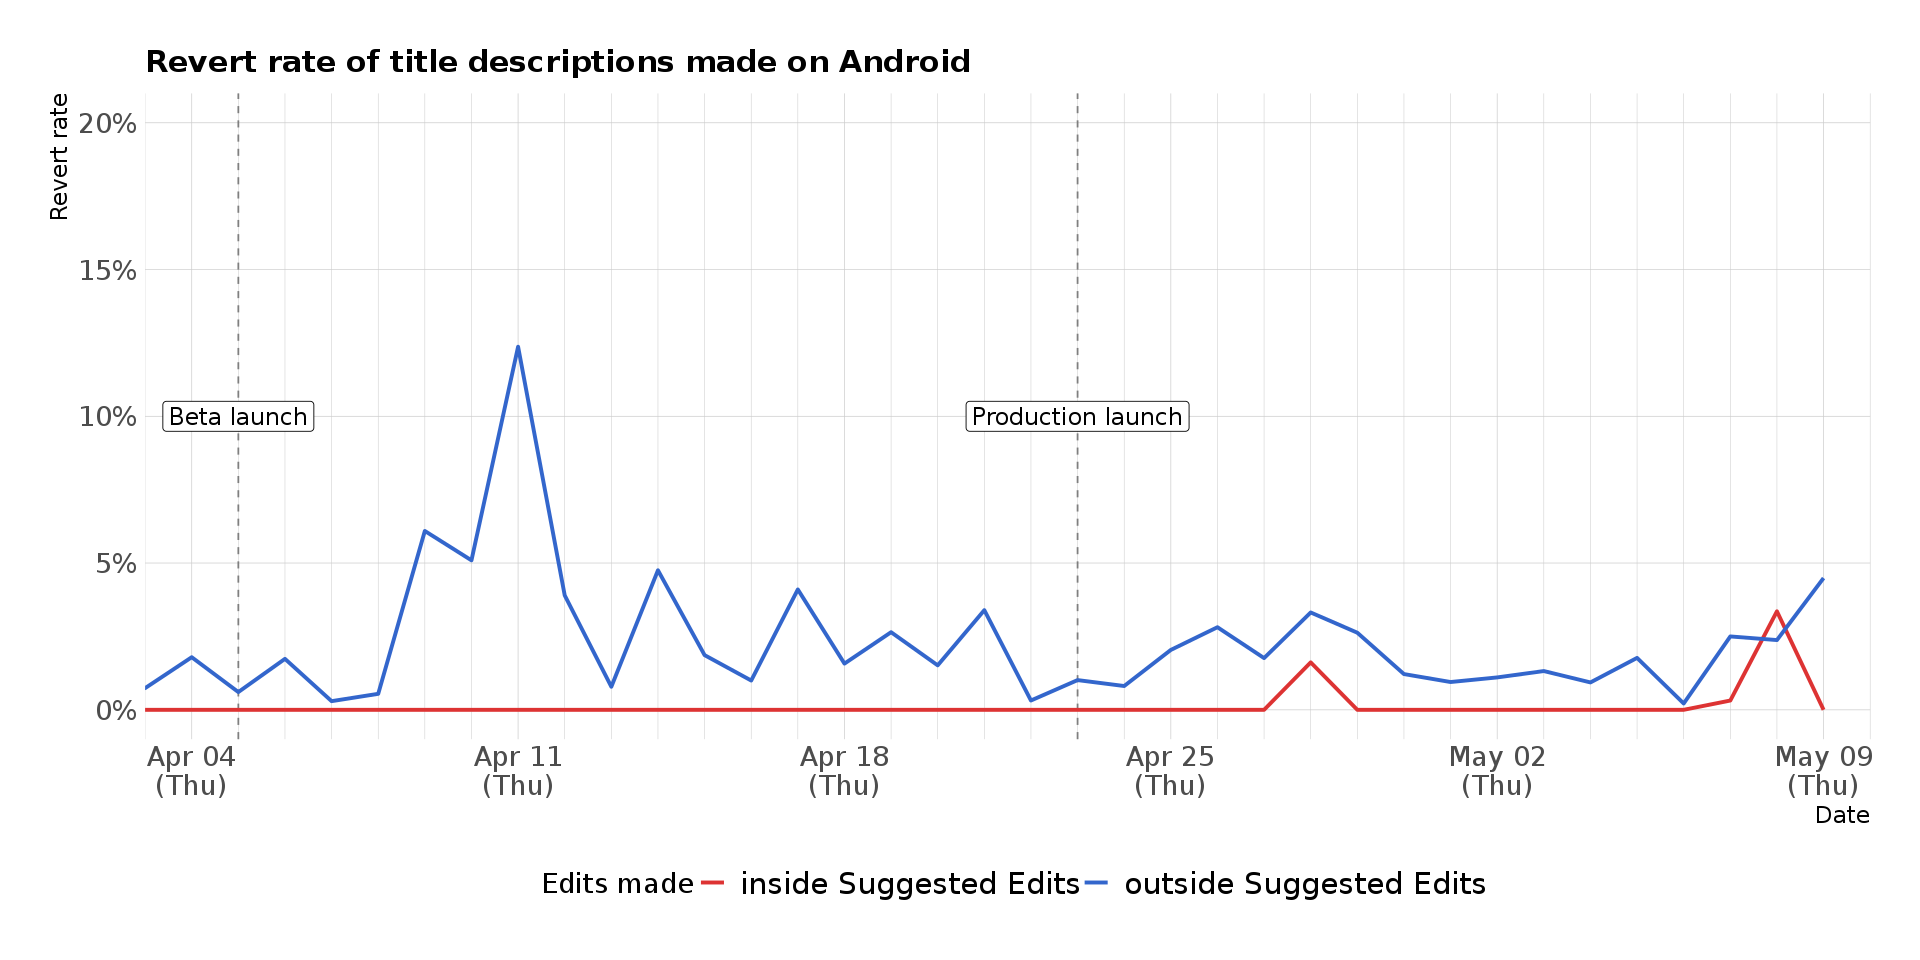

In [20]:
options(repr.plot.width = 16, repr.plot.height = 8)
revert_status_data %>%
    group_by(rev_date, made) %>%
    summarize(revert_rate = mean(reverted)) %>%
    ggplot() +
    geom_vline(aes(xintercept = date), data = feature_release_dates, linetype = "dashed", color = "gray50") +
    geom_label(aes(x = date, y = 0.1, label = release), data = feature_release_dates, size = 5) +
    geom_line(aes(x = rev_date, y = revert_rate, color = made), size = 1.1) +
    scale_color_manual(values = c("inside Suggested Edits" = "#dd3333", "outside Suggested Edits" = "#3366cc")) +
    scale_y_continuous(labels = scales::percent_format(1), minor_breaks = NULL) +
    scale_x_date(date_breaks = "7 days", date_minor_breaks = "1 day", date_labels = "%b %d\n(%a)", expand = c(0, 1)) +
    coord_cartesian(xlim = edit_date_range, ylim = c(0, 0.2)) +
    hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold",
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14) +
    theme(legend.position = "bottom", panel.grid.minor.y = element_blank(), legend.text = element_text(size = 18)) +
    labs(x = "Date", y = "Revert rate", color = "Edits made",
         title = "Revert rate of title descriptions made on Android")

## Usage stats

In [21]:
el_query <- "USE event;
SELECT
  useragent.wmf_app_version AS app_version,
  event.app_install_id AS install_id,
  event.session_token AS session_id,
  MIN(SUBSTR(event.client_dt, 1, 10)) AS session_start_date,
  COUNT(1) AS n_suggested_edits_sessions,
  SUM(event.time_spent) AS total_time_spent, -- in seconds
  SUM(event.help_opened) AS n_help, -- total times user looked at help
  SUM(event.scorecard_opened) AS n_scorecard, -- total times user looked at scorecard,
  COALESCE(SUM(description_addition.impressions) + SUM(description_translation.impressions), 0L) AS n_suggestions, -- total impressions
  COALESCE(SUM(description_addition.unique_clicks) + SUM(description_translation.unique_clicks), 0L) AS n_accepts, -- total unique clickthroughs
  COALESCE(SUM(description_addition.total_clicks) + SUM(description_translation.total_clicks), 0L) AS n_clicks, -- total clickthroughs
  COALESCE(SUM(description_addition.cancels) + SUM(description_translation.cancels), 0L) AS n_cancels,
  COALESCE(SUM(description_addition.successes) + SUM(description_translation.successes), 0L) AS n_edits -- total Wikidata descriptions edits
FROM MobileWikiAppSuggestedEdits
LATERAL VIEW JSON_TUPLE(event.edit_tasks, 'add-description', 'translate-description') edit_tasks
  AS add_desc, translate_desc
LATERAL VIEW JSON_TUPLE(edit_tasks.add_desc, 'impressions', 'clicks', 'suggestions_clicked', 'cancels', 'successes') description_addition
  AS impressions, total_clicks, unique_clicks, cancels, successes
LATERAL VIEW JSON_TUPLE(edit_tasks.translate_desc, 'impressions', 'clicks', 'suggestions_clicked', 'cancels', 'successes') description_translation
  AS impressions, total_clicks, unique_clicks, cancels, successes
WHERE (
    (year = 2019 AND month = 4 AND day >= 23) -- launch week
    OR (year = 2019 AND month > 4) -- remainder of the year
    OR year > 2019 -- going forward
  )
  AND INSTR(useragent.wmf_app_version, '-r-') > 0
GROUP BY wiki, useragent.wmf_app_version, event.app_install_id, event.session_token;"

In [22]:
events <- suppress_messages_warnings(wmf::query_hive(el_query)) %>%
    dplyr::as_tibble() %>%
    mutate(
        session_start_date = as.Date(session_start_date),
        release = sub("^([0-9\\.]+)-([a-z]+)-[0-9]{4}-[0-9]{2}-[0-9]{2}$", "\\2", app_version),
        version = sub("^([0-9\\.]+)-([a-z]+)-[0-9]{4}-[0-9]{2}-[0-9]{2}$", "\\1", app_version),
        release = ifelse(release == "r", "production", release)
    ) %>%
    keep_where(release %in% c("production")) %>%
    mutate(release = paste(polloi::capitalize_first_letter(release), "release"))

In [23]:
per_user_stats <- events %>%
    arrange(install_id, session_start_date) %>%
    group_by(install_id, date = session_start_date) %>%
    summarize(
        app_sessions = n(),
        suggested_edits_sessions = sum(n_suggested_edits_sessions),
        med_time_per_session = median(total_time_spent),
        total_time_spent = sum(total_time_spent),
        total_suggestions = sum(n_suggestions),
        total_acceptances = sum(n_accepts),
        total_clicks = sum(n_clicks),
        total_cancels = sum(n_cancels),
        total_edits = sum(n_edits),
        clickthrough_rate = total_acceptances / total_suggestions,
        cancel_rate = inf2na(nan2na(total_cancels / total_clicks)),
        success_rate = inf2na(nan2na(total_edits / total_acceptances))
        # suggested_edit_rate = nan2na(total_edits / total_suggestions)
    ) %>%
    mutate(returned = length(date) > 1 & date != min(date)) %>%
    ungroup

In [24]:
critical_value <- function(conf_level = 0.95) {
    return(abs(qnorm((1 - conf_level) / 2)))
}
avg_ci <- function(x, conf_level = 0.95) {
    n <- sum(!is.na(x))
    m <- mean(x, na.rm = TRUE)
    s <- sd(x, na.rm = TRUE) / sqrt(n)
    return(m + c(-1, 1) * critical_value(conf_level) * s)
}
prop_ci <- function(x, conf_level = 0.95) {
    n <- sum(!is.na(x))
    p <- mean(x, na.rm = TRUE)
    s <- sqrt((p * (1 - p)) / n)
    return(max(0, p + c(-1, 1) * critical_value(conf_level) * s))
}
avg_ci_lower <- function(x, conf_level = 0.95) {
    return(avg_ci(x, conf_level)[1])
}
avg_ci_upper <- function(x, conf_level = 0.95) {
    return(avg_ci(x, conf_level)[2])
}
prop_ci_lower <- function(x, conf_level = 0.95) {
    return(prop_ci(x, conf_level)[1])
}
prop_ci_upper <- function(x, n, conf_level = 0.95) {
    return(prop_ci(x, conf_level)[2])
}

In [25]:
daily_stats <- per_user_stats %>%
    group_by(date) %>%
    summarize(
        total_users = n(), total_edits = sum(total_edits),
        returning_users = sum(returned, na.rm = TRUE),
        app_sessions_per_user = median(app_sessions),
        suggested_edits_sessions_per_user = median(suggested_edits_sessions),
        time_spent_middle = median(total_time_spent, na.rm = TRUE),
        time_spent_10 = quantile(total_time_spent, 0.1, na.rm = TRUE),
        time_spent_90 = quantile(total_time_spent, 0.9, na.rm = TRUE),
        time_spent_25 = quantile(total_time_spent, 0.25, na.rm = TRUE),
        time_spent_75 = quantile(total_time_spent, 0.75, na.rm = TRUE),
        # clickthrough_rate_lower = quantile(clickthrough_rate, 0.1, na.rm = TRUE),
        # clickthrough_rate_middle = median(clickthrough_rate, na.rm = TRUE),
        # clickthrough_rate_upper = quantile(clickthrough_rate, 0.9, na.rm = TRUE),
        # success_rate_lower = quantile(success_rate, 0.1, na.rm = TRUE),
        # success_rate_middle = median(success_rate, na.rm = TRUE),
        # success_rate_upper = quantile(success_rate, 0.9, na.rm = TRUE),
        clickthrough_rate_lower = max(0, avg_ci_lower(clickthrough_rate, 0.8)),
        clickthrough_rate_middle = mean(clickthrough_rate, na.rm = TRUE),
        clickthrough_rate_upper = min(1, avg_ci_upper(clickthrough_rate, 0.8)),
        success_rate_lower = max(0, avg_ci_lower(success_rate, 0.8)),
        success_rate_middle = mean(success_rate, na.rm = TRUE),
        success_rate_upper = min(1, avg_ci_upper(success_rate, 0.8))
        # edit_rate_lower = quantile(suggested_edit_rate, 0.1, na.rm = TRUE),
        # edit_rate_middle = median(suggested_edit_rate, na.rm = TRUE),
        # edit_rate_upper = quantile(suggested_edit_rate, 0.9, na.rm = TRUE)
    ) %>%
    ungroup

### Engagement

**Note**: using in-app analytics (cf. [T213460](https://phabricator.wikimedia.org/T213460); not sampled, although not all users are opted-in to sharing usage data with us) we can also look at relative daily usage of the Suggested Edits feature, including:

- opening the Editor Tasks screen
- opening the scorecard or help within that screen
- browsing suggestions
- clicking to add descriptions on some suggestions but then cancelling out
- submitting descriptions

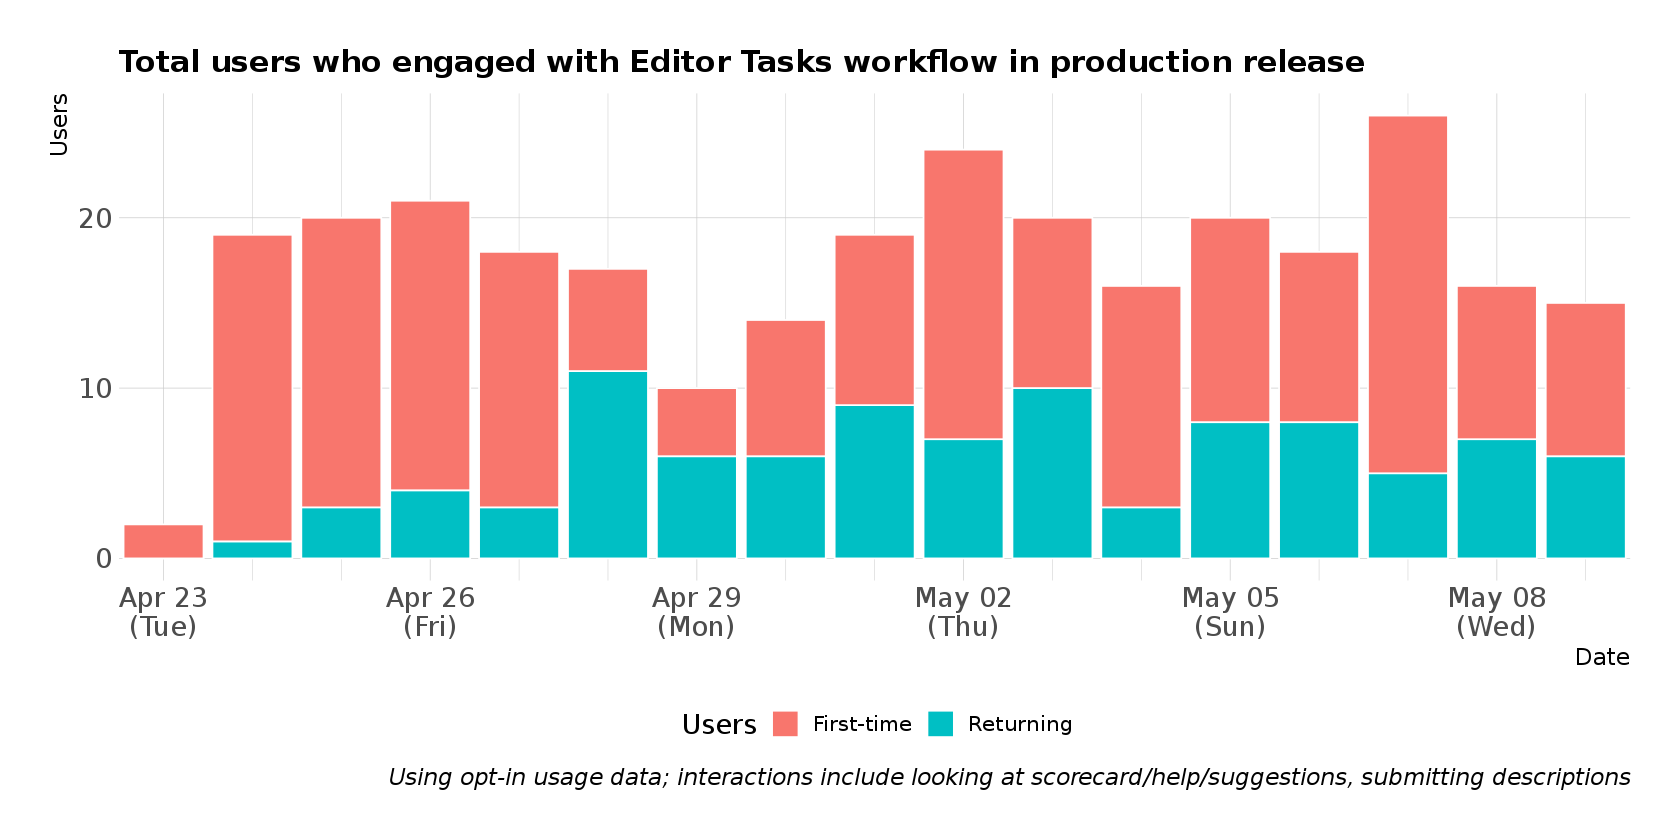

In [26]:
options(repr.plot.width = 14, repr.plot.height = 7)
daily_stats %>%
    mutate(fresh_users = total_users - returning_users) %>%
    select(date, `First-time` = fresh_users, Returning = returning_users) %>%
    gather(users, count, -date) %>%
    ggplot() +
    # geom_vline(aes(xintercept = date), linetype = "solid", data = feature_release_dates) +
    geom_col(aes(x = date, y = count, fill = users), position = "stack", color = "white") +
    scale_y_continuous(labels = compress) +
    scale_x_date(date_breaks = "3 days", date_minor_breaks = "1 day", date_labels = "%b %d\n(%a)", expand = c(0, 0.5)) +
    coord_cartesian(xlim = usage_date_range, expand = TRUE) +
    hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold",
                            caption_size = 14, axis_title_size = 14, subtitle_size = 14) +
    theme(legend.position = "bottom", panel.grid.minor.y = element_blank()) +
    labs(
        title = "Total users who engaged with Editor Tasks workflow in production release",
        caption = "Using opt-in usage data; interactions include looking at scorecard/help/suggestions, submitting descriptions",
        x = "Date", y = "Users", fill = "Users"
    )

### Help and Scorecard

While in the Editor Tasks workflow, users can look at a scorecard of their contributions or look up helpful information (which opens [mw:Wikimedia Apps/Suggested edits](https://www.mediawiki.org/wiki/Wikimedia_Apps/Suggested_edits) in their preferred web browser). In the last 30 days of usage, we can calculate the proportion of people who looked at either and how many of those users looked at help/scorecard multiple times in a single Editor Tasks sub-session.

In [27]:
events %>%
    keep_where(session_start_date >= (max(events$session_start_date) - 30)) %>%
    group_by(install_id) %>%
    summarize(help = sum(n_help) > 0, scorecard = sum(n_scorecard) > 0) %>%
    ungroup %>%
    gather(looked_at, yes, -install_id) %>%
    group_by(looked_at) %>%
    summarize(n_yes = sum(yes), n_total = n()) %>%
    ungroup %>%
    mutate(prop = n_yes / n_total) %>%
    dplyr::transmute(
        looked_at = paste("Users who, during any session, looked at", looked_at),
        stat = sprintf("%.1f%% (%.0f/%.0f)", 100 * prop, n_yes, n_total)
    ) %>%
    spread(looked_at, stat)

"Users who, during any session, looked at help","Users who, during any session, looked at scorecard"
33.0% (66/200),59.0% (118/200)


Proportion of users who looked at help multiple times in any one of their sub-sessions, out of users who looked at help at least once in all of their interactions with the Editor Tasks workflow:

In [28]:
events %>%
    keep_where(session_start_date >= (max(events$session_start_date) - 30)) %>%
    group_by(install_id) %>%
    summarize(
        help = any(n_help > 0),
        help_multi = any(n_help > 1)
    ) %>%
    ungroup %>%
    keep_where(help) %>%
    summarize(n_yes = sum(help_multi), n_total = n()) %>%
    ungroup %>%
    mutate(prop = n_yes / n_total) %>%
    dplyr::transmute(Users = sprintf("%.1f%% (%.0f/%.0f)", 100 * prop, n_yes, n_total))

Users
25.8% (17/66)


Proportion of users who looked at their scorecard multiple times in any one of their sub-sessions, out of users who looked at their scorecard at least once in all of their interactions with the Editor Tasks workflow:

In [29]:
events %>%
    keep_where(session_start_date >= (max(events$session_start_date) - 30)) %>%
    group_by(install_id) %>%
    summarize(
        scorecard = any(n_scorecard > 0),
        scorecard_multi = any(n_scorecard > 1)
    ) %>%
    ungroup %>%
    keep_where(scorecard) %>%
    summarize(n_yes = sum(scorecard_multi), n_total = n()) %>%
    ungroup %>%
    mutate(prop = n_yes / n_total) %>%
    dplyr::transmute(Users = sprintf("%.1f%% (%.0f/%.0f)", 100 * prop, n_yes, n_total))

Users
42.4% (50/118)


### Time spent

The in-app analytics also enable us to look at how much time users spend in the Editor Tasks workflow. While browsing suggestions of articles to add descriptions to, users may also open the article to read it, which pauses the timer. If the user taps the system Back button, they go back to the Editor Tasks workflow and the timer resumes, but if they exit to the feed from article view, that terminates their Editor Tasks session and a session summary is sent to us.

The user may go into the Editor Tasks screen multiple times during their overall session, so when we refer to "total time spent" we are referring to the sum of the time spent across those "sub-sessions" within the overall session. When we refer to "total time spent per day", we are referring to how much time a user spent in the Editor Tasks workflow across all their sessions in a given day.

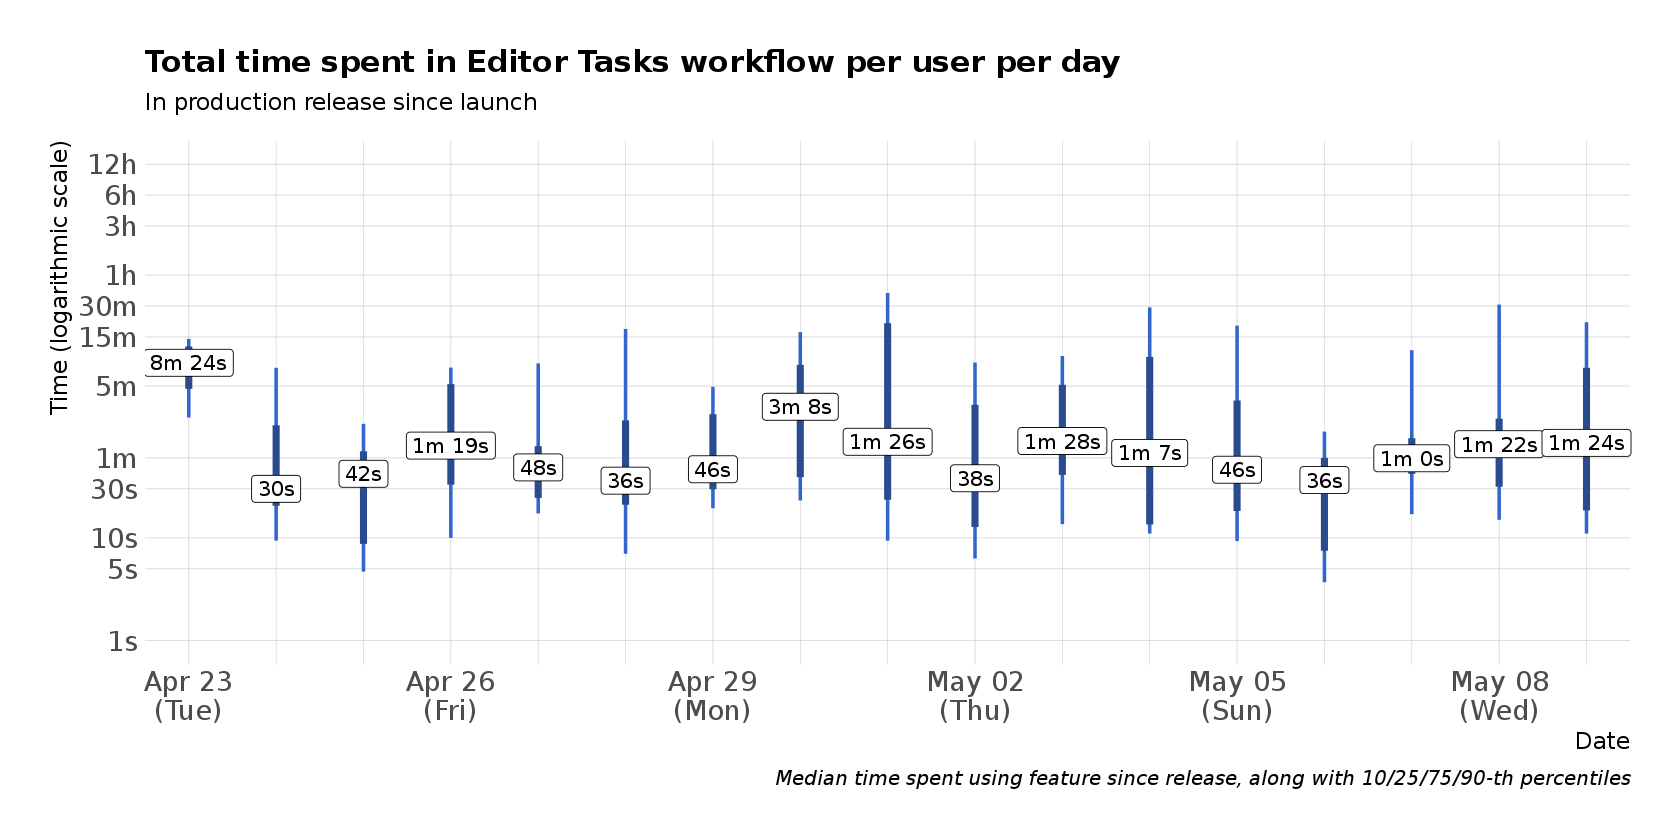

In [30]:
options(repr.plot.width = 14, repr.plot.height = 7)
ggplot(daily_stats) +
    # geom_vline(aes(xintercept = date), linetype = "dashed", data = feature_release_dates) +
    geom_segment(aes(x = date, xend = date, y = time_spent_10, yend = time_spent_90),
                 size = 1, color = "#3366cc") +
    geom_segment(aes(x = date, xend = date, y = time_spent_25, yend = time_spent_75),
                 size = 2, color = "#2a4b8d") +
    # geom_ribbon(aes(x = date, ymin = time_spent_lower, ymax = time_spent_upper), alpha = 0.3) +
    # geom_line(aes(x = date, y = time_spent_middle)) +
    geom_label(
        aes(x = date, y = time_spent_middle, label = tolower(lubridate::seconds_to_period(round(time_spent_middle)))),
        size = 4.5
    ) +
    scale_x_date(expand = c(0, 0.5), date_minor_breaks = "1 day", date_breaks = "3 days", date_labels = "%b %d\n(%a)") +
    scale_y_log10(label = function(x) {
        y <- tolower(lubridate::seconds_to_period(round(x)))
        z <- gsub(" 0[hms]", "", y)
        return(z)
    }, breaks = c(1, 5, 10, 30, 60, 60 * 5, 60 * 15, 60 * 60 * c(0.5, 1, 3, 6, 12))) +
    coord_cartesian(ylim = c(1, 60 * 60 * 12), xlim = usage_date_range) +
    hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold",
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14) +
    theme(legend.position = "bottom", panel.grid.minor.y = element_blank()) +
    labs(
        title = "Total time spent in Editor Tasks workflow per user per day",
        x = "Date", y = "Time (logarithmic scale)",
        subtitle = "In production release since launch",
        caption = "Median time spent using feature since release, along with 10/25/75/90-th percentiles"
    )

### Interaction with suggestions

In the Editor Tasks workflow, the user can look at many suggestions before seeing one that they would like to add a description for (or translate a description for, as the case may be). In the same sub-session, they may even go back to a previously seen suggestion and decide that they want to add/translate a description after all. They may also tap ("click") on a suggestion, change their mind, then change their mind again, and tap on it once more. We track both kinds of clicks: *unique* clicks (maximum 1 click per suggested article) and *total* clicks.

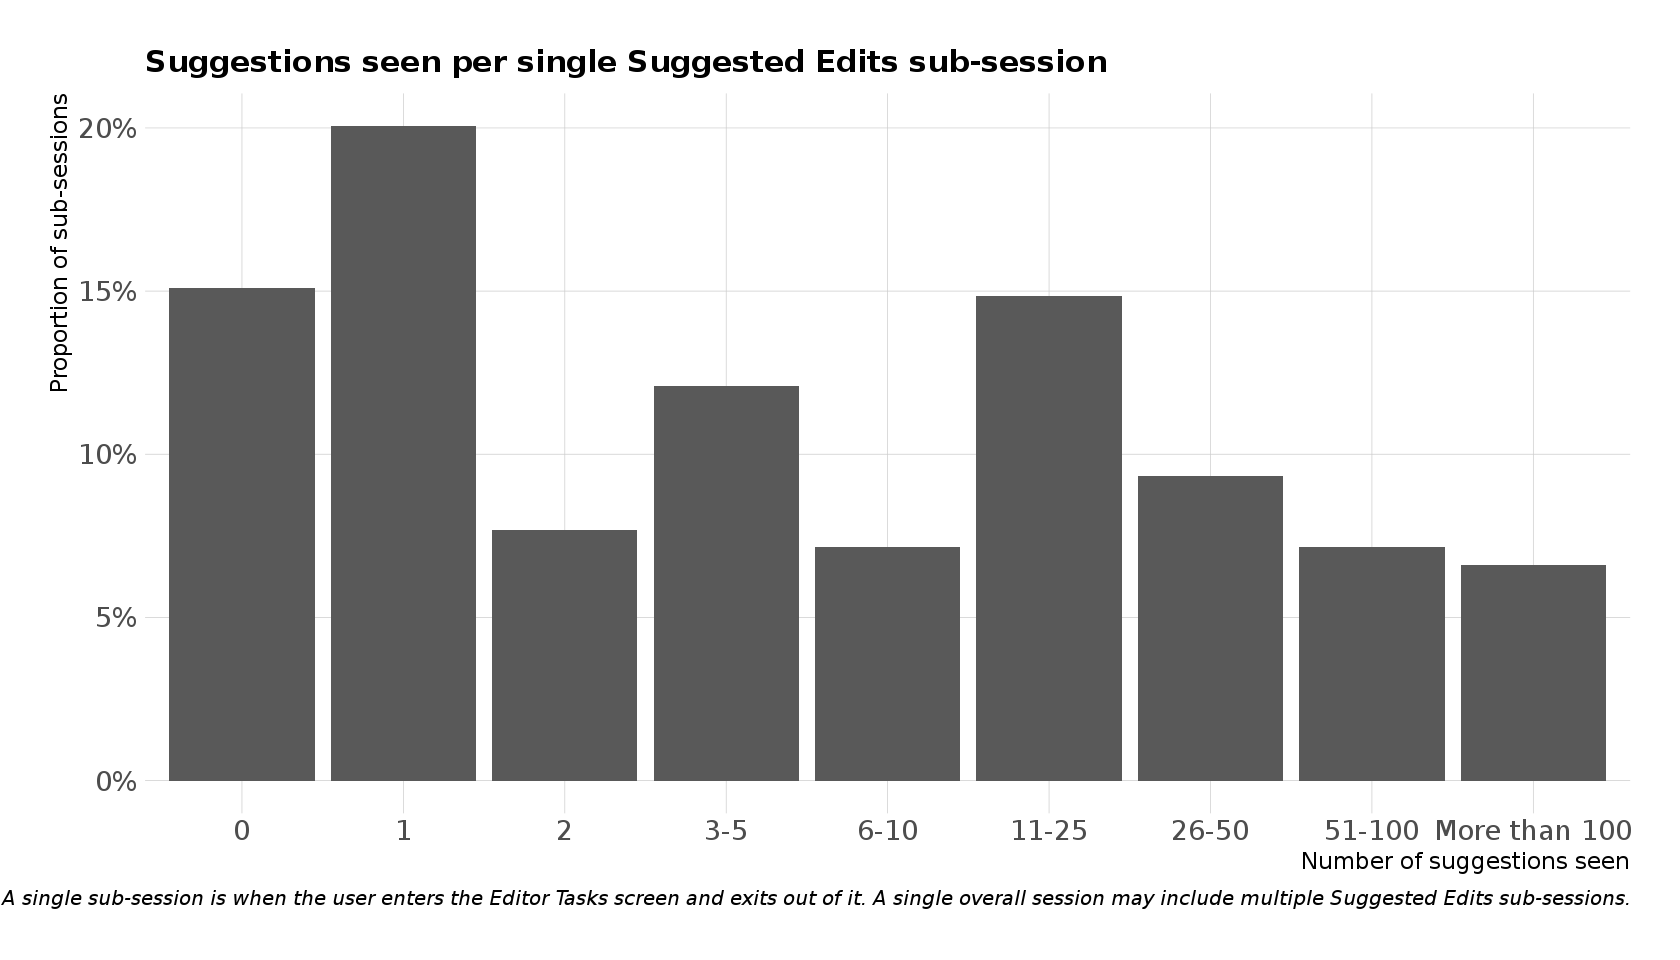

In [31]:
options(repr.plot.width = 14, repr.plot.height = 8)

suggestions_seen_per_subsession <- events %>%
    keep_where(session_start_date >= (max(events$session_start_date) - 30)) %>%
    mutate(f_suggestions = cut(n_suggestions, c(-Inf, 0, 1, 2, 5, 10, 25, 50, 100, Inf)))

levels(suggestions_seen_per_subsession$f_suggestions) <- c(
  "0", "1", "2", "3-5", "6-10", "11-25", "26-50", "51-100", "More than 100"
)

suggestions_seen_per_subsession %>%
    dplyr::count(f_suggestions) %>%
    mutate(prop = n / sum(n)) %>%
    ggplot(aes(x = f_suggestions, y = prop)) +
    geom_col() +
    scale_y_continuous(labels = scales::percent_format(1)) +
    hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold",
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14, strip_text_size = 16) +
    theme(legend.position = "bottom", panel.grid.minor.y = element_blank()) +
    labs(
        x = "Number of suggestions seen", y = "Proportion of sub-sessions",
        title = "Suggestions seen per single Suggested Edits sub-session",
        caption = "A single sub-session is when the user enters the Editor Tasks screen and exits out of it. A single overall session may include multiple Suggested Edits sub-sessions."
    )

The following shows the daily breakdowns of three engagement metrics:

- "**Suggestion clickthrough rate**": % of suggestions clicked on (unique clicks / impressions)
- "**Edit per clicked suggestion rate**": % of time the user clicked on a suggestion and then made the edit (edits / unique clicks)
<!-- - "**Edit per suggestion rate**": % of suggestions which resulted in an edit -->

In [32]:
tidy_rates <- daily_stats %>%
    select(date, dplyr::contains("rate")) %>%
    gather("metric", "value", -date) %>%
    mutate(key = sub(".*_rate_([a-z]+)$", "\\1", metric), metric = sub("^([a-z]+)_rate.*", "\\1", metric)) %>%
    spread(key, value, fill = 0) %>%
    mutate(metric = factor(metric, c("clickthrough", "success", "edit"), c("Suggestion clickthrough rate", "Edit per clicked suggestion rate", "Edit per suggestion rate")))

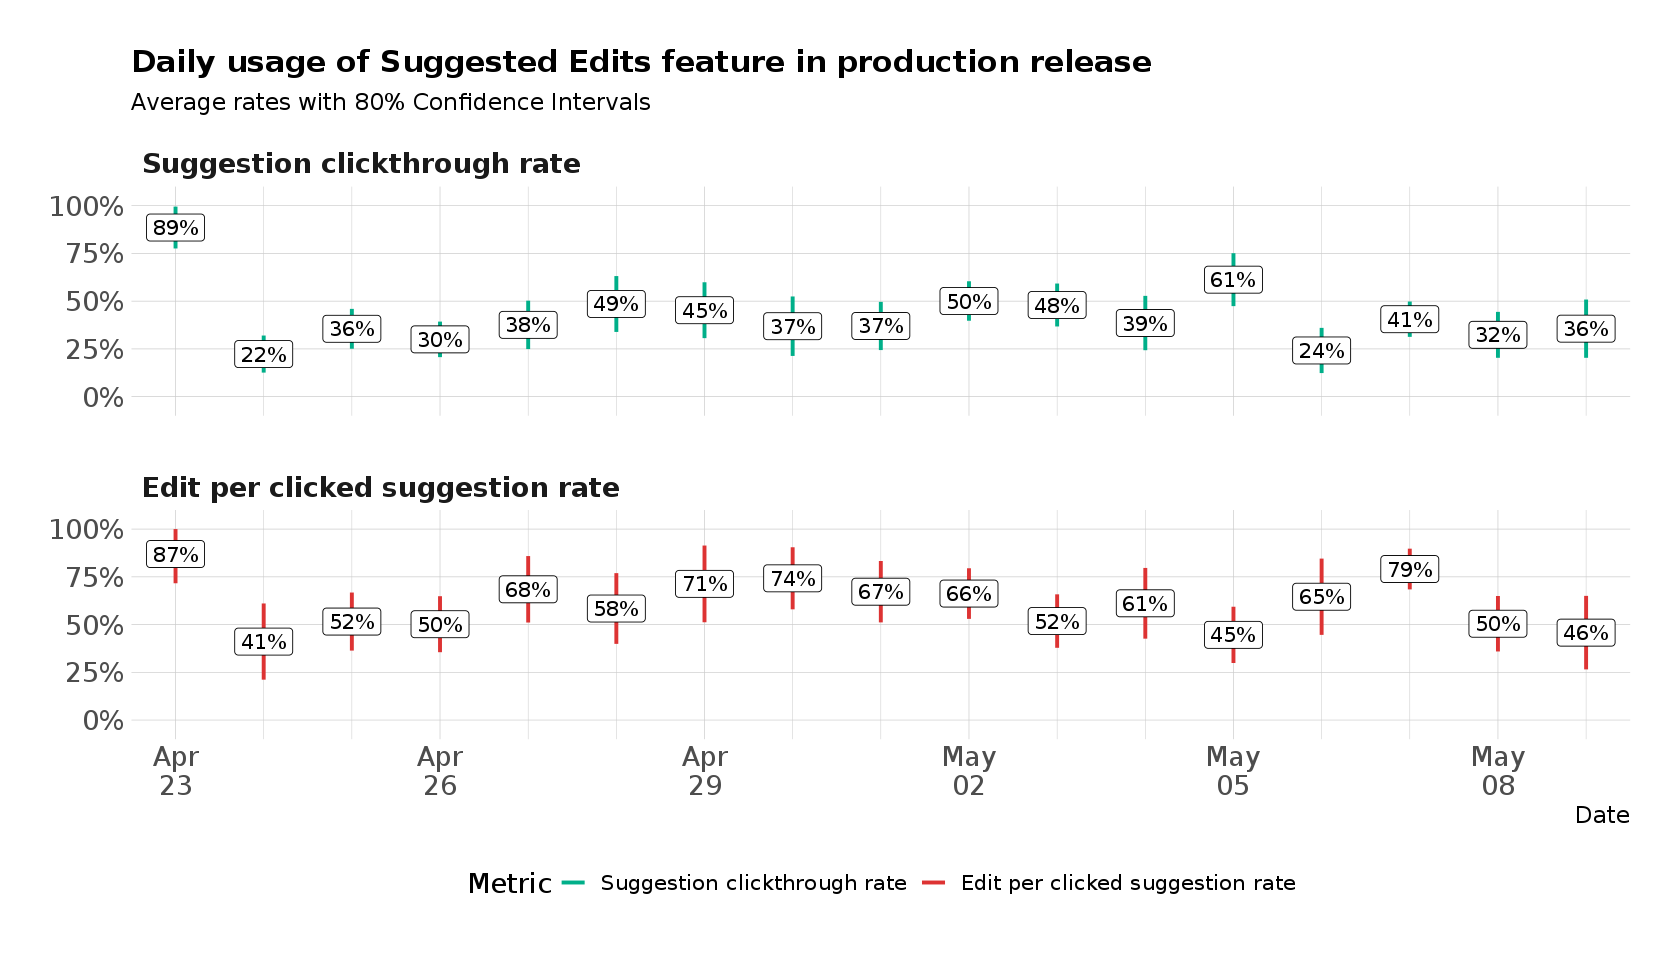

In [33]:
options(repr.plot.width = 14, repr.plot.height = 8)
rate_colors <- c(
    "Edit per clicked suggestion rate" = "#dd3333",
    "Edit per suggestion rate" = "#ac6600",
    "Suggestion clickthrough rate" = "#00af89"
)
tidy_rates %>%
    # keep_where(release == "Production release") %>%
    ggplot() +
    geom_segment(aes(x = date, xend = date, y = lower, yend = upper, color = metric), size = 1.1) +
    # geom_ribbon(aes(x = date, ymin = lower, ymax = upper, fill = metric), alpha = 0.25) +
    # geom_line(aes(x = date, y = middle, color = metric)) +
    geom_label(aes(x = date, y = middle, label = sprintf("%.0f%%", 100 * middle)), size = 4.5) +
    scale_color_manual(values = rate_colors) +
    scale_fill_manual(values = rate_colors) +
    scale_y_continuous(labels = scales::percent, limits = c(0, 1), expand = c(0, 0.1)) +
    scale_x_date(expand = c(0, 0.5), date_breaks = "3 day", date_minor_breaks = "1 day", date_labels = "%b\n%d") +
    coord_cartesian(xlim = usage_date_range) +
    facet_wrap(~ metric, ncol = 1) +
    hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold",
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14, strip_text_size = 16) +
    theme(legend.position = "bottom", panel.grid.minor.y = element_blank()) +
    labs(
        title = "Daily usage of Suggested Edits feature in production release",
        # subtitle = "Median per-user rates, along with 10th and 90th percentiles",
        subtitle = "Average rates with 80% Confidence Intervals",
        x = "Date", y = NULL, color = "Metric", fill = "Metric"
    )

## Retention stats

By looking at Wikidata edit data (rather than usage data from opted-in users), we can find out how many editors use the Suggested Edits feature to make contributions just once or multiple times:

In [34]:
editor_data %>%
    keep_where(suggested_edits > 0) %>%
    group_by(user_id) %>%
    summarize(returned = n() > 1) %>%
    dplyr::count(returned) %>%
    mutate(returned = factor(
        returned,
        c(FALSE, TRUE),
        c("for only one day", "on multiple days")
    )) %>%
    mutate(prop = sprintf("%.1f%%", 100 * n / sum(n))) %>%
    rename(
        `Made contributions with Suggested Edits (SE)` = returned,
        `Android app editors` = n,
        `Proportion (out of total who have contributed with SE at least once)` = prop
    )

Made contributions with Suggested Edits (SE),Android app editors,Proportion (out of total who have contributed with SE at least once)
for only one day,100,63.3%
on multiple days,58,36.7%


In [35]:
consecutive_streaks <- editor_data %>%
    keep_where(suggested_edits > 0) %>%
    arrange(user_id, date) %>%
    group_by(user_id) %>%
    mutate(
        differences = na2zero(c(NA, diff(date))),
        sequence = cumsum(differences != 1)
    ) %>%
    group_by(user_id, sequence) %>%
    summarize(
        started = min(date),
        days_lasted = n(),
        total_edits = sum(suggested_edits)
    ) %>%
    ungroup

Longest consecutive streaks of making contributions through Suggested Edits:

In [36]:
consecutive_streaks %>%
    dplyr::top_n(3, days_lasted) %>%
    arrange(dplyr::desc(days_lasted), dplyr::desc(total_edits)) %>%
    head(10) %>%
    mutate(user = sprintf("(%.0f)", 1:n())) %>%
    select(user, started, days_lasted, total_edits) %>%
    rename(
        User = user,
        `Streak started` = started,
        `Days lasted` = days_lasted,
        `Total edits made through SE` = total_edits
    )

User,Streak started,Days lasted,Total edits made through SE
(1),2019-04-27,9,987
(2),2019-05-06,5,189
(3),2019-04-30,5,125
(4),2019-04-02,5,13


When looking at the last 30 days of *usage*<sup>†</sup> data (so as to not deflate the rate two months later with re-installs and users who uninstalled the app or switched devices), we get the following retention rates:

- "**Next-day retention***": % of users who went into the Editor Tasks screen again the next day
- "**Week retention**": % of users who went into the Editor Tasks screen again within 7 days (not necessarily after initial usage)
- "**Month retention**": % of users who went into the Editor Tasks screen again within 30 days (not necessarily after initial usage)

That is, this is looking at engagement with the feature -- including just looking at suggestions or the scorecard; not necessarily actually making contributions through it.

<sup>†</sup>: from app users who are opted in to sharing usage data with us

In [37]:
retention_rates <- per_user_stats %>%
    select(install_id, date, returned) %>%
    keep_where(date >= (max(per_user_stats$date) - 30)) %>%
    # For debugging:
    # rbind(
    #     dplyr::tibble(
    #         release = c("Beta release", "Production release"),
    #         install_id = c("01ffb902-ec29-4e90-9c7c-5e30400a6ab8", "01b8c744-c6c3-422c-859d-2820d677429e"),
    #         date = as.Date(c("2019-04-06", "2019-04-27")),
    #         returned = TRUE
    #     )
    # ) %>%
    arrange(install_id, date) %>%
    group_by(install_id) %>%
    mutate(last_usage = dplyr::lag(date), days_since = date - last_usage) %>%
    summarize(
        `2` = any(days_since == 1), # user used the feature again the next day
        `7` = any(days_since <= 7), # user used the feature multiple times per week
        `30` = any(days_since <= 30) # user used the feature multiple times per month
    ) %>%
    ungroup %>%
    gather(days, retained, -install_id) %>%
    mutate(retained = ifelse(is.na(retained), FALSE, retained)) %>%
    group_by(days) %>%
    summarize(retention_rate = mean(retained), retained = sum(retained), n_users = n()) %>%
    ungroup %>%
    mutate(days = factor(days, c(2, 7, 30), c("Next-day retention", "Week retention", "Month retention")))

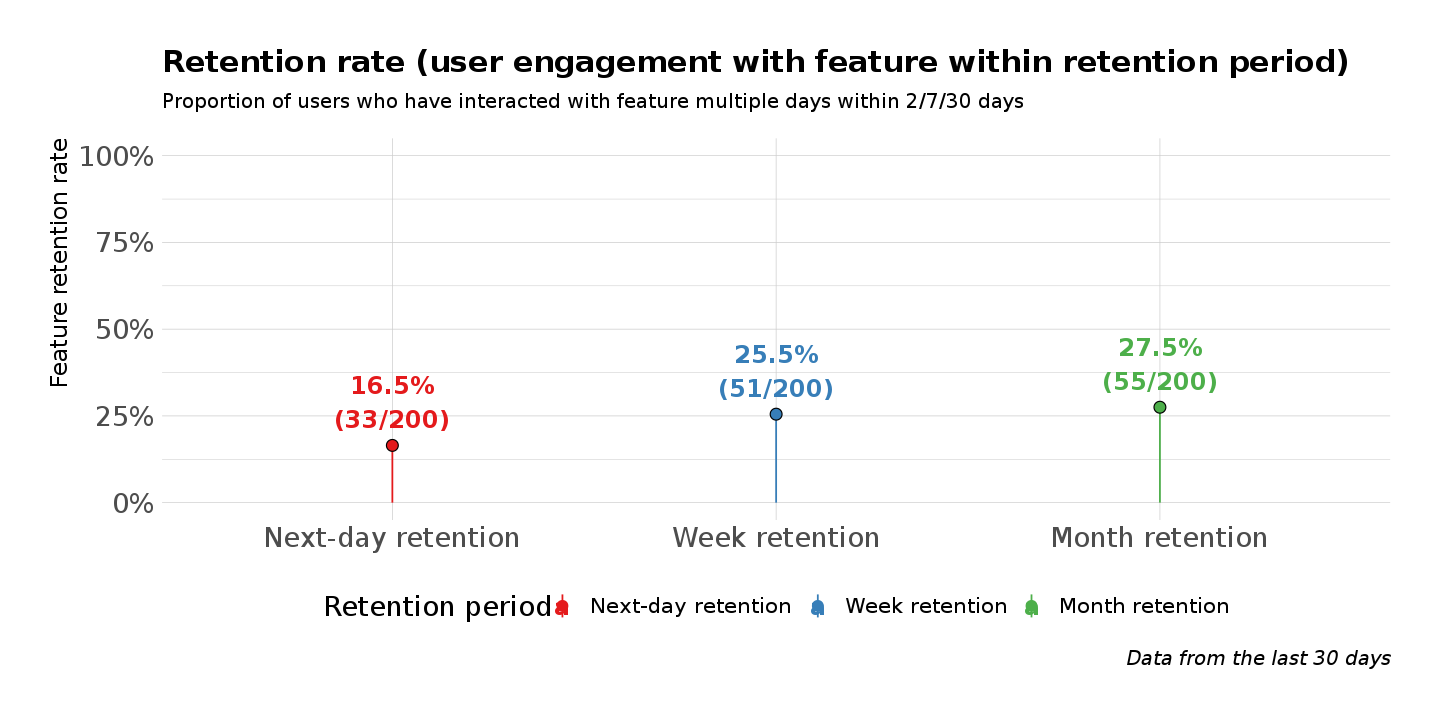

In [38]:
options(repr.plot.width = 12, repr.plot.height = 6)
ggplot(retention_rates, aes(x = factor(days), color = factor(days))) +
    geom_pointrange(aes(ymin = 0, y = retention_rate, ymax = retention_rate), position = position_dodge(width = 0.8)) +
    geom_point(aes(y = retention_rate), position = position_dodge(width = 0.8), color = "black", shape = 1, size = 3) +
    geom_text(
        aes(y = retention_rate + 0.05, label = sprintf("%.1f%%\n(%.0f/%.0f)", 100 * retention_rate, retained, n_users)),
        position = position_dodge(width = 0.8), vjust = "bottom", size = 5, fontface = "bold"
    ) +
    scale_color_brewer(palette = "Set1") +
    scale_y_continuous(limits = c(0, 1), labels = scales::percent_format(1)) +
    hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, caption_size = 12, axis_title_size = 14) +
    theme(legend.position = "bottom") +
    labs(
        x = NULL, y = "Feature retention rate", color = "Retention period",
        title = "Retention rate (user engagement with feature within retention period)",
        subtitle = "Proportion of users who have interacted with feature multiple days within 2/7/30 days",
        caption = "Data from the last 30 days"
    )

For more information or to bring up issues with this report, contact <a href="https://www.mediawiki.org/wiki/User:MPopov_(WMF)">Mikhail Popov</a>. For details on in-app analytics instrumentation, contact <a href="https://www.mediawiki.org/wiki/User:DBrant_(WMF)">Dmitry Brant</a>. For more information on Suggested Edits feature, contact <a href="https://www.mediawiki.org/wiki/User:CGauthier_(WMF)">Charlotte Gauthier</a>.

In [39]:
cat("Report generated on", format(lubridate::now(), "%Y-%m-%d at %H:%M:%S UTC"))

Report generated on 2019-05-10 at 13:02:23 UTC